# Rainforest main with attention + CNN blocks

Densenet_2
version 3
- longer cut time, larger image, more epoch, 1 more cnn layer,


In [1]:
! pip install loguru

     |████████████████████████████████| 57 kB 1.4 MB/s 
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
! pip install -q tensorflow-io

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [3]:
# # Set your own project id here
# PROJECT_ID = ''
# from google.cloud import storage
# storage_client = storage.Client(project=PROJECT_ID)

In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_io as tfio
from keras.layers.advanced_activations import PReLU
import numpy as np
from pathlib import Path
import io
import matplotlib.pyplot as plt
import soundfile as sf
import librosa
from kaggle_datasets import KaggleDatasets # this is only specific to kaggle though
from tqdm import tqdm
import pandas as pd
from sklearn.model_selection import StratifiedKFold
import seaborn as sns
from IPython.display import Audio, Image # display audio files, image files in notebook
from loguru import logger
import os 
import subprocess 
import random
from functools import partial 
import pickle

In [5]:
# check the package version to get reproducible env 
# source: https://www.kaggle.com/rtatman/get-the-versions-of-imported-packages
import pkg_resources
import types
def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            # Split ensures you get root package, 
            # not just imported function
            name = val.__name__.split(".")[0]

        elif isinstance(val, type):
            name = val.__module__.split(".")[0]

        # Some packages are weird and have different
        # imported names vs. system names
        if name == "PIL":
            name = "Pillow"
        elif name == "sklearn":
            name = "scikit-learn"

        yield name
imports = list(set(get_imports()))

requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name!="pip":
        requirements.append((m.project_name, m.version))

for r in requirements:
    print("{}=={}".format(*r))

tqdm==4.55.1
tensorflow==2.4.0
seaborn==0.11.1
scikit-learn==0.23.2
pandas==1.2.0
numpy==1.19.5
matplotlib==3.3.3
librosa==0.8.0


# FUNCTIONS

In [6]:

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)


In [7]:
class configuration_manager:
    """Loads configurations"""
    
    def __init__(self,config_dict):
        self.load_config(config_dict)
    
    
    def load_config(self,config_dict):
        self.parse_params = config_dict['parse_params']
        self.data_params = config_dict['data_params']
        self.model_params = config_dict['model_params']

# Configurations

In [8]:

##################
# configurations 
##################
cfg = {
    'parse_params': {
        'cut_time': 15,
    },
    'data_params': {
        'sample_time': 6, # assert 60 % sample_time == 0
        'spec_fmax': 24000.0,
        'spec_fmin': 40.0,
        'spec_mel': 224,
        'mel_power': 2,
        'img_shape': (384,768), #(224, 512), # (768,384)
        "class_n" : 24,
        "SR":48000, # all wav's sample rate 
        "mel_transformation":"log"
    },
    'model_params': {
        'batchsize_per_tpu': 16,
        'iteration_per_epoch': 64,
        'epoch': 25, #25,#18,
        'arch': tf.keras.applications.ResNet50,
        'arch_preprocess': tf.keras.applications.densenet.preprocess_input, # https://stackoverflow.com/questions/47555829/preprocess-input-method-in-keras/47556342
        'freeze_to': 0,  # Freeze to backbone.layers[:freeze_to]. If None, all layers in the backbone will be freezed. 0 means none will be frozen
        'loss': {
            'fn': tfa.losses.SigmoidFocalCrossEntropy, # can we try another loss 
            'params': {},
        },
        'optim': {
            'fn': tfa.optimizers.RectifiedAdam,
            'params': {'lr': 2e-3, 'total_steps': 18*64, 'warmup_proportion': 0.3, 'min_lr': 1e-6},
        },
        'mixup': True
    }
}


# load configurations to config_manager 
# will need to refactor to use yaml 

configuration_load = configuration_manager(cfg)

In [9]:
CUT = configuration_load.parse_params['cut_time']
SR = configuration_load.data_params['SR']     # all wave's sample rate may be 48k

TIME = configuration_load.data_params['sample_time']

FMAX = configuration_load.data_params['spec_fmax']
FMIN = configuration_load.data_params['spec_fmin']
N_MEL = configuration_load.data_params['spec_mel']
mel_power = configuration_load.data_params['mel_power']
mel_transformation = configuration_load.data_params['mel_transformation']
HEIGHT, WIDTH = configuration_load.data_params['img_shape']

CLASS_N = configuration_load.data_params['class_n']

# Set seed settings

In [10]:
seed_everything(1)

## TPU / GPU distribution settings

In [11]:
# activate tpu
# source: https://www.tensorflow.org/guide/tpu
# this is ran at the beginning of the program 

# detect and init the TPU
resolver = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(cluster_resolver = resolver)


# use this statement to check if TPU is connected (tip: can also use with cpu.gpu)
print("All devices: ", tf.config.list_logical_devices('TPU'))

# set tpu distribution strategy - https://www.tensorflow.org/guide/tpu
# later need to use strategy.run / strategy.scope for model creation for it to be in tpu
strategy = tf.distribute.TPUStrategy(resolver)
# strategy = tf.distribute.experimental.TPUStrategy(resolver)

# if gpu 
# strategy = tf.distribute.MirroredStrategy()

All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU')]


In [12]:
# # tensorflow 2.4
# try: # detect TPUs
#     # NEW: in Tensorflow 2.4
#     tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect() 
#     strategy = tf.distribute.TPUStrategy(tpu)
# except ValueError: # otherwise detect GPUs
#     strategy = tf.distribute.MirroredStrategy() # single-GPU or multi-GPU

## Optimization for dataset

In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [14]:
AUTOTUNE

-1

# Start of Code

## Loading data

In [15]:
# get cache location of the dataset 
GCS_DS_PATH = KaggleDatasets().get_gcs_path()

In [16]:
GCS_DS_PATH

'gs://kds-f51ed7a43af9681723162f6fde7b71b4d56fdf5407d61e7f55d16175'

In [17]:
TRAIN_TFREC = GCS_DS_PATH +"/tfrecords/train"
TEST_TFREC = GCS_DS_PATH +"/tfrecords/test"

In [18]:
# lets try to load one shard of the TFrecords and parse 
raw_dataset = tf.data.TFRecordDataset((TRAIN_TFREC+'/00-148.tfrec'))
raw_dataset

<TFRecordDatasetV2 shapes: (), types: tf.string>

In [19]:
# https://www.tensorflow.org/tutorials/load_data/tfrecord#reading_a_tfrecord_file

# as per kaggle data description
feature_description = {
    'recording_id': tf.io.FixedLenFeature([], tf.string, default_value=''),
    'audio_wav': tf.io.FixedLenFeature([], tf.string, default_value=''),
    'label_info': tf.io.FixedLenFeature([], tf.string, default_value=''),
}
parse_dtype = {
    'audio_wav': tf.float32,
    'recording_id': tf.string,
    'species_id': tf.int32,
    'songtype_id': tf.int32,
    't_min': tf.float32,
    'f_min': tf.float32,
    't_max': tf.float32,
    'f_max':tf.float32,
    'is_tp': tf.int32
}

@tf.function
def _parse_function(example_proto):
    """
    Use with map on the shards of TFrecords. Iterate through each element
    """
    # Parse the input `tf.train.Example` proto using the dictionary above.
    sample = tf.io.parse_single_example(example_proto, feature_description)
    # mono, (2880000, 1) - where 60 secs * 48000 sample rate 
    wav, _ = tf.audio.decode_wav(sample['audio_wav'], desired_channels=1) 
    # 0: recording_id 1: species_id 2:song_type_id, 3:t_min 4:f_min, 5: t_max, 6:f_max, 7: is_tp
    label_info = tf.strings.split(sample['label_info'], sep='"')[1] 
    labels = tf.strings.split(label_info, sep=';')
    print(labels.numpy())
    
    @tf.function
    def _cut_audio(label):
        items = tf.strings.split(label, sep=',')
        spid = tf.squeeze(tf.strings.to_number(items[0], tf.int32)) # squeeze removes any dim that is 1 (x,1,x) to (x,x)
        soid = tf.squeeze(tf.strings.to_number(items[1], tf.int32))
        tmin = tf.squeeze(tf.strings.to_number(items[2]))
        fmin = tf.squeeze(tf.strings.to_number(items[3]))
        tmax = tf.squeeze(tf.strings.to_number(items[4]))
        fmax = tf.squeeze(tf.strings.to_number(items[5]))
        tp = tf.squeeze(tf.strings.to_number(items[6], tf.int32))
        
        # we do not need all 60seconds. Lets just cut 10 seconds around 
        # the important label ranges using tmin and tmax
        tmax_s = tmax * tf.cast(SR, tf.float32)
        tmin_s = tmin * tf.cast(SR, tf.float32)
        cut_s = tf.cast(CUT * SR, tf.float32)
        all_s = tf.cast(60 * SR, tf.float32)
        tsize_s = tmax_s - tmin_s
        cut_min = tf.cast(
            tf.maximum(0.0, 
                tf.minimum(tmin_s - (cut_s - tsize_s) / 2,
                           tf.minimum(tmax_s + (cut_s - tsize_s) / 2, all_s) - cut_s)
            ), tf.int32
        )
        
 
        cut_max = cut_min + CUT * SR
    
        # for debugging - tensorflow needs tf based function to print 
        #tf.print(tmin)
        #tf.print(tmax)
        
        _sample = {
            'audio_wav': tf.reshape(wav[cut_min:cut_max], [CUT*SR]),
            'recording_id': sample['recording_id'],
            'species_id': spid,
            'songtype_id': soid,
            't_min': tmin - tf.cast(cut_min, tf.float32)/tf.cast(SR, tf.float32), # shift left and let cut_min be the new 0
            'f_min': fmin,
            't_max': tmax - tf.cast(cut_min, tf.float32)/tf.cast(SR, tf.float32), # shift left and let cut_min be the new 0
            'f_max': fmax,
            'is_tp': tp
        }
        return _sample
    
    samples = tf.map_fn(_cut_audio, labels, dtype=parse_dtype)
    return samples

In [20]:
# https://www.tensorflow.org/tutorials/load_data/tfrecord#reading_a_tfrecord_file

# as per kaggle data description
feature_description = {
    'recording_id': tf.io.FixedLenFeature([], tf.string, default_value=''),
    'audio_wav': tf.io.FixedLenFeature([], tf.string, default_value=''),
    'label_info': tf.io.FixedLenFeature([], tf.string, default_value=''),
}
parse_dtype = {
    'audio_wav': tf.float32,
    'recording_id': tf.string,
    'species_id': tf.int32,
    'songtype_id': tf.int32,
    't_min': tf.float32,
    'f_min': tf.float32,
    't_max': tf.float32,
    'f_max':tf.float32,
    'is_tp': tf.int32
}

@tf.function
def _parse_function(example_proto):
    """
    Use with map on the shards of TFrecords. Iterate through each element
    """
    # Parse the input `tf.train.Example` proto using the dictionary above.
    sample = tf.io.parse_single_example(example_proto, feature_description)
    # mono, (2880000, 1) - where 60 secs * 48000 sample rate 
    wav, _ = tf.audio.decode_wav(sample['audio_wav'], desired_channels=1) 
    # 0: recording_id 1: species_id 2:song_type_id, 3:t_min 4:f_min, 5: t_max, 6:f_max, 7: is_tp
    label_info = tf.strings.split(sample['label_info'], sep='"')[1] 
    labels = tf.strings.split(label_info, sep=';')
    
    #@tf.function
    def _cut_audio(label):
        items = tf.strings.split(label, sep=',')
        spid = tf.squeeze(tf.strings.to_number(items[0], tf.int32)) # squeeze removes any dim that is 1 (x,1,x) to (x,x)
        soid = tf.squeeze(tf.strings.to_number(items[1], tf.int32))
        tmin = tf.squeeze(tf.strings.to_number(items[2]))
        fmin = tf.squeeze(tf.strings.to_number(items[3]))
        tmax = tf.squeeze(tf.strings.to_number(items[4]))
        fmax = tf.squeeze(tf.strings.to_number(items[5]))
        tp = tf.squeeze(tf.strings.to_number(items[6], tf.int32))
        
        # we do not need all 60seconds. Lets just cut 10 seconds around 
        # the important label ranges using tmin and tmax
        tmax_s = tmax * tf.cast(SR, tf.float32)
        tmin_s = tmin * tf.cast(SR, tf.float32)
        cut_s = tf.cast(CUT * SR, tf.float32)
        all_s = tf.cast(60 * SR, tf.float32)
        tsize_s = tmax_s - tmin_s
        cut_min = tf.cast(
            tf.maximum(0.0, 
                tf.minimum(tmin_s - (cut_s - tsize_s) / 2,
                           tf.minimum(tmax_s + (cut_s - tsize_s) / 2, all_s) - cut_s)
            ), tf.int32
        )
        
 
        cut_max = cut_min + CUT * SR
    
        # for debugging - tensorflow needs tf based function to print 
        #tf.print(tmin)
        #tf.print(tmax)
        
        _sample = {
            'audio_wav': tf.reshape(wav[cut_min:cut_max], [CUT*SR]),
            'recording_id': sample['recording_id'],
            'species_id': spid,
            'songtype_id': soid,
            't_min': tmin - tf.cast(cut_min, tf.float32)/tf.cast(SR, tf.float32), # shift left and let cut_min be the new 0
            'f_min': fmin,
            't_max': tmax - tf.cast(cut_min, tf.float32)/tf.cast(SR, tf.float32), # shift left and let cut_min be the new 0
            'f_max': fmax,
            'is_tp': tp
        }
        return _sample
    
    samples = tf.map_fn(_cut_audio, labels, dtype=parse_dtype)
    return samples

In [21]:
# lets see how does the output looks like if we were to take the TFrecords and 
# map it via _parse_function. .map makes the function disable eager since its a graph
x= raw_dataset.take(1).map(_parse_function) # iterator list of objects containing dict

for sample in x:
    print((sample))
    

{'audio_wav': <tf.Tensor: shape=(1, 720000), dtype=float32, numpy=
array([[0.00125122, 0.00701904, 0.00183105, ..., 0.0168457 , 0.01541138,
        0.00946045]], dtype=float32)>, 'recording_id': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'003bec244'], dtype=object)>, 'species_id': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([14], dtype=int32)>, 'songtype_id': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>, 't_min': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([7.206665], dtype=float32)>, 'f_min': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([2531.25], dtype=float32)>, 't_max': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([7.7933655], dtype=float32)>, 'f_max': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([5531.25], dtype=float32)>, 'is_tp': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>}


In [22]:
# create function for augmentation
# for train, we will randomly sample (based on configs) from the 10 second audio (which we extracted out from 60sec)
@tf.function
def _cut_wav(x):
    # random cut in training
    
    # here we ensure at if we start sampling at max 4 second, this 4 second mark must be > than the tmax. else, we should
    # just use tmax as the 
    cut_min = tf.random.uniform([], maxval=tf.minimum((CUT-TIME)*SR, tf.cast(x['t_max']*SR, tf.int32)), dtype=tf.int32)
    cut_max = cut_min + TIME * SR
    cutwave = tf.reshape(x['audio_wav'][cut_min:cut_max], [TIME*SR])
    y = {}
    y.update(x)
    y['audio_wav'] = cutwave
    y['t_min'] = tf.maximum(0.0, x['t_min'] - tf.cast(cut_min, tf.float32) / SR)
    y['t_max'] = tf.maximum(0.0, x['t_max'] - tf.cast(cut_min, tf.float32) / SR)
    return y
    
@tf.function
def _cut_wav_val(x):
    # center crop in validation
    cut_min = tf.minimum((CUT-TIME)*SR // 2, tf.cast((x['t_min'] + x['t_max']) / 2 * SR, tf.int32))
    cut_max = cut_min + TIME * SR
    cutwave = tf.reshape(x['audio_wav'][cut_min:cut_max], [TIME*SR])
    y = {}
    y.update(x)
    y['audio_wav'] = cutwave
    y['t_min'] = tf.maximum(0.0, x['t_min'] - tf.cast(cut_min, tf.float32) / SR)
    y['t_max'] = tf.maximum(0.0, x['t_max'] - tf.cast(cut_min, tf.float32) / SR)
    return y


In [23]:
# pradicate function later to filter our dataset 
# to be used in dataset.filter 

@tf.function
def _filtTP(x):
    """
    pradicate output function for .filter()
    """
    return x['is_tp'] == 1

In [24]:
def show_wav(sample, ax):
    wav = sample["audio_wav"].numpy()
    rate = SR
    ax.plot(np.arange(len(wav)) / rate, wav)
    ax.set_title(
        sample["recording_id"].numpy().decode()
        + ("/%d" % sample["species_id"])
        + ("TP" if sample["is_tp"] else "FP"))

    return Audio((wav * 2**15).astype(np.int16), rate=rate)

In [25]:
# # we need to interate our dataset to apply this function
# def show_wav(sample, ax):
#     wav = sample["audio_wav"].numpy()
#     rate = SR
#     ax.plot(np.arange(len(wav)) / rate, wav)
#     ax.set_title(
#         sample["recording_id"].numpy().decode()
#         + ("/%d" % sample["species_id"])
#         + ("TP" if sample["is_tp"] else "FP"))

#     return Audio((wav * 2**15).astype(np.int16), rate=rate)

# fig, ax = plt.subplots(figsize=(15, 3))


# either this 
# for sample in x:
#     show_wav((sample), ax)


# or this
#show_wav(next(x.as_numpy_iterator(),ax))

# Signal domain

In [26]:
# lets code a function for dataset for mel-spectrogram conversion
@tf.function
def convert_mel_spectrogram(sample,
                            mel_power = 2, 
                            sr = 48000, 
                            n_mel = 128, 
                            lower_edge_hertz=125.0, 
                            upper_edge_hertz=3800.0,
                            transformation = "log1p"):
    """
    https://towardsdatascience.com/getting-to-know-the-mel-spectrogram-31bca3e2d9d0
    https://www.tensorflow.org/api_docs/python/tf/signal/linear_to_mel_weight_matrix
    
    Taking log on mel 
    https://stackoverflow.com/questions/53925401/difference-between-mel-spectrogram-and-an-mfcc/54326385#:~:text=The%20mel%2Dspectrogram%20is%20often,models%20like%20Gaussian%20Mixture%20Models.
    https://carlthome.github.io/posts/signal-reconstruction-from-spectrograms%20/
    
    This function is for use with .map on datasets. Apply transformation to each element in
    dataset
    
    Mel_power is when we take the power of the fft output, default to 2
    """
    
    # get stft output, (frames t, fft_unique_bins)  where fft_unique_bins are the number of complex elements
    # fft_length is alise of fft, frame_step is aliase of hop_length , frame_length is aliase of window
    D = tf.signal.stft(sample['audio_wav'],
                       fft_length=2048,
                       frame_length=2048, 
                       frame_step=512)
    # compute the power
    P = tf.abs(D) ** mel_power 
    
    # get the mel scale, input n_mels (mel bin), sampling rate and the fft_length 
    # mel bin is given the frequency spectrum, how many evenly space frequencies do we separate them 
    A = tf.signal.linear_to_mel_weight_matrix(num_mel_bins=n_mel,
                                              num_spectrogram_bins=P.shape[-1], # fft_unique_bins
                                              sample_rate=sr,
                                              lower_edge_hertz = lower_edge_hertz,
                                              upper_edge_hertz= upper_edge_hertz
                                         )
    # we just need to do matrix multiplication 
    # we can either use tensordot axes 1 or matmul 
    #M = tf.tensordot(P,A,1)
    M = tf.matmul(P,A)
    
    # TODO: add log-magnitute 
    
    
    # return in dictionary (like dataset)
    output = {}
    output = {**sample}
    if transformation == "log1p":
        output['audio_spec'] = tf.transpose(tf.math.log1p(M)) # to convert (t,mel_bins), 
    else:
        output['audio_spec'] = tf.transpose(tf.math.log(M + 0.0001)) # to convert (t,mel_bins), 
        
    return output 
    

In [27]:

# first define our params (might need to tune)
convert_mel_spectrogram_param = partial(convert_mel_spectrogram,
                                       mel_power = mel_power, 
                                        sr = SR, n_mel = N_MEL, 
                                        lower_edge_hertz=FMIN, 
                                        upper_edge_hertz=FMAX,
                                       transformation = mel_transformation)


In [28]:
# lets test our mel output 

convert_mel_spectrogram_param(next(x.as_numpy_iterator()))['audio_spec']

<tf.Tensor: shape=(224, 1403, 1), dtype=float32, numpy=
array([[[-3.231691 ],
        [-4.130913 ],
        [-3.826307 ],
        ...,
        [-3.38616  ],
        [-3.5725675],
        [-3.280924 ]],

       [[-2.4579525],
        [-4.2134266],
        [-3.3355045],
        ...,
        [-2.2360134],
        [-4.762869 ],
        [-2.486737 ]],

       [[-2.1559572],
        [-3.9128914],
        [-3.0339377],
        ...,
        [-1.9339576],
        [-4.4636283],
        [-2.1847508]],

       ...,

       [[-2.3637846],
        [-2.7011445],
        [-2.4217494],
        ...,
        [-3.0459673],
        [-3.0460875],
        [-2.6517656]],

       [[-2.6478503],
        [-2.797353 ],
        [-3.033568 ],
        ...,
        [-2.0709357],
        [-2.2238927],
        [-2.6920397]],

       [[-3.0142112],
        [-3.1323957],
        [-3.1102598],
        ...,
        [-2.797612 ],
        [-2.732666 ],
        [-2.3842561]]], dtype=float32)>

In [29]:
# without any params 
convert_mel_spectrogram(next(x.as_numpy_iterator()))['audio_spec']

<tf.Tensor: shape=(128, 1403, 1), dtype=float32, numpy=
array([[[0.06148228],
        [0.00125521],
        [0.00398555],
        ...,
        [0.05882104],
        [0.04749417],
        [0.04616372]],

       [[0.0461166 ],
        [0.00093439],
        [0.0029679 ],
        ...,
        [0.04410585],
        [0.0355623 ],
        [0.03456035]],

       [[0.08433934],
        [0.01475586],
        [0.00033451],
        ...,
        [0.04056974],
        [0.00395665],
        [0.00408526]],

       ...,

       [[0.0608612 ],
        [0.02765047],
        [0.02816722],
        ...,
        [0.01875429],
        [0.04946857],
        [0.0280141 ]],

       [[0.05695904],
        [0.12840545],
        [0.15227112],
        ...,
        [0.02380823],
        [0.0157669 ],
        [0.03715896]],

       [[0.04859797],
        [0.14735574],
        [0.12694405],
        ...,
        [0.01894506],
        [0.01151328],
        [0.02085936]]], dtype=float32)>

# Visualization

In [30]:
# side note: we need to add unbatch to the dataset 
# without unbatch: next(x.as_numpy_iterator())['is_tp'] returns array([1], dtype=int32)
# with unbatch: next(x.unbatch().as_numpy_iterator())['is_tp'] returns 1
# since our _filtTP looks for == 1, we need to unbatch


parsed_dataset = raw_dataset.map(_parse_function).unbatch().filter(_filtTP).map(_cut_wav).map(convert_mel_spectrogram_param)

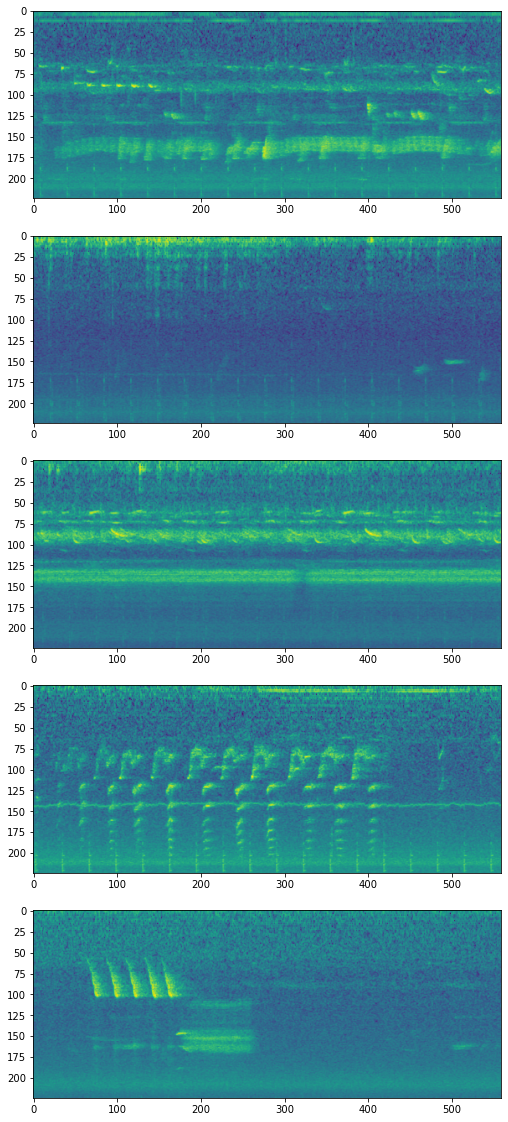

In [31]:
fig, axes = plt.subplots(figsize = (20,20),nrows = 5)
for i,sam in enumerate(parsed_dataset):
    if i >4:
        break
    axes[i].imshow(sam['audio_spec'])

In [32]:
# using the kernel's visualization

import librosa.display
import matplotlib.patches as patches

def show_spectrogram(sample, ax, showlabel=False):
    S_dB = sample["audio_spec"].numpy()
    img = librosa.display.specshow(S_dB, x_axis='time',
                             y_axis='mel', sr=SR,
                             fmax=FMAX, fmin=FMIN, ax=ax, cmap='magma')
    ax.set(title=f'Mel-frequency spectrogram of {sample["recording_id"].numpy().decode()}')
    sid, fmin, fmax, tmin, tmax, istp = (
            sample["species_id"], sample["f_min"], sample["f_max"], sample["t_min"], sample["t_max"], sample["is_tp"])
    ec = '#00ff00' if istp == 1 else '#0000ff'
    # bounding box
    ax.add_patch(
        patches.Rectangle(xy=(tmin, fmin), width=tmax-tmin, height=fmax-fmin, ec=ec, fill=False)
    )

    if showlabel:
        ax.text(tmin, fmax, 
        f"{sid.numpy().item()} {'tp' if istp == 1 else 'fp'}",
        horizontalalignment='left', verticalalignment='bottom', color=ec, fontsize=16)

/opt/conda/lib/python3.7/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/opt/conda/lib/python3.7/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


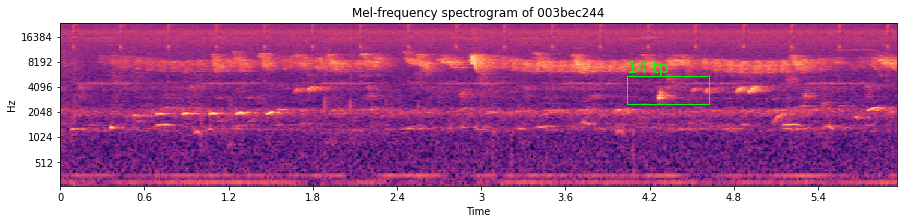

In [33]:
# random cut augmentation, where we sample uniform the different cut points
fig, ax = plt.subplots(figsize=(15,3)) 
show_spectrogram(next(iter(parsed_dataset)), ax, showlabel=True) # next iter only seems to take the first

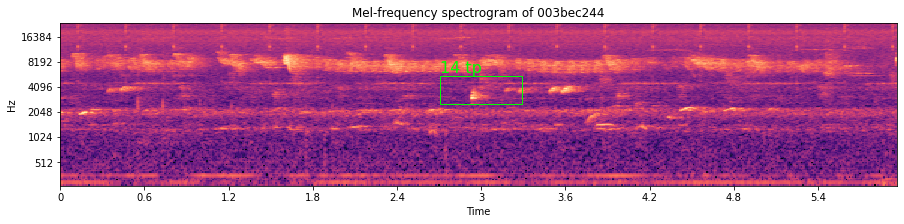

In [34]:
# in validation, annotations will come to the center
# here we apply the validation augmentation 
fig, ax = plt.subplots(figsize=(15,3))
show_spectrogram(next(iter(raw_dataset.map(_parse_function).unbatch().filter(_filtTP).map(_cut_wav_val).map(convert_mel_spectrogram_param))), ax, showlabel=True)

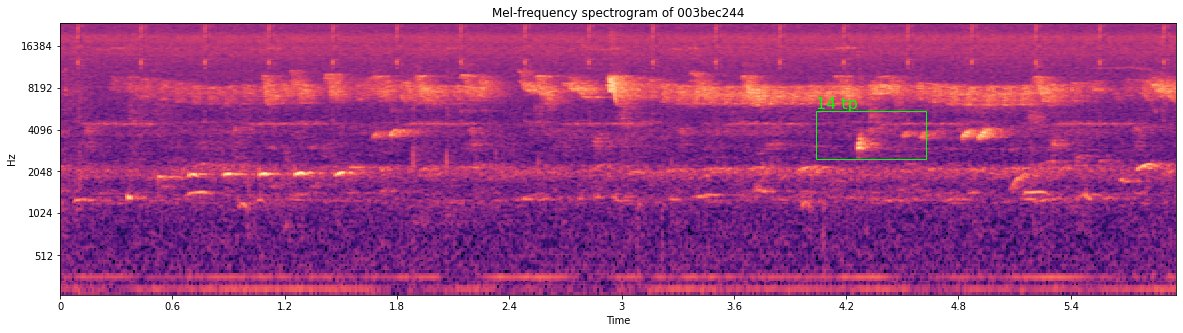

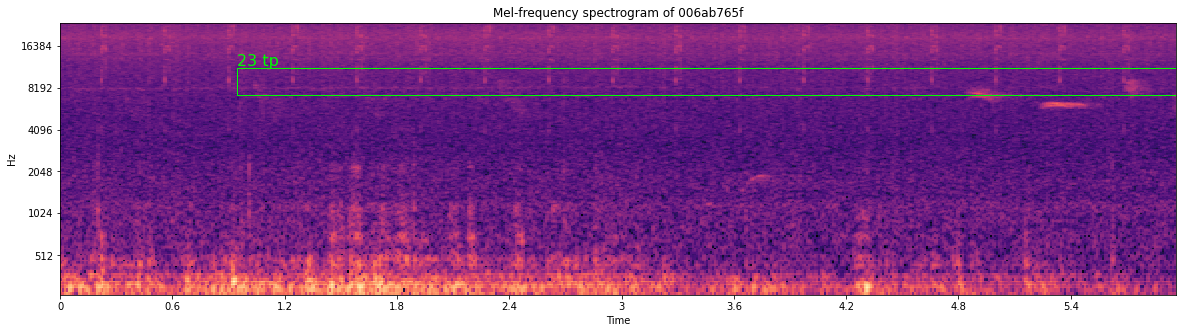

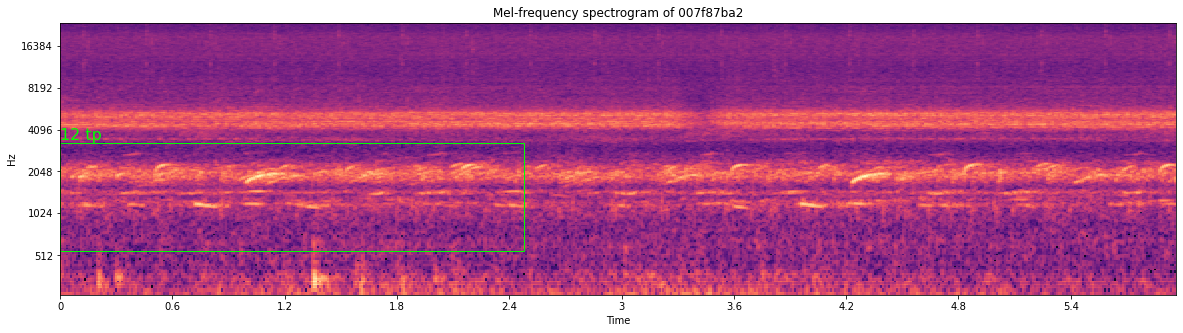

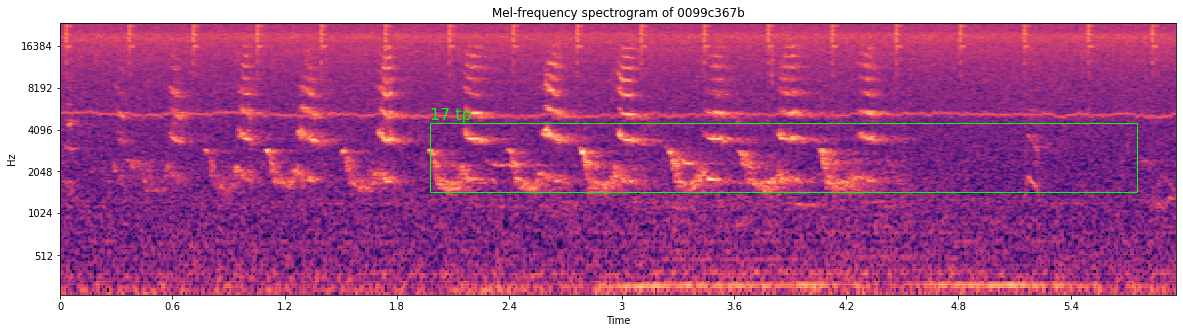

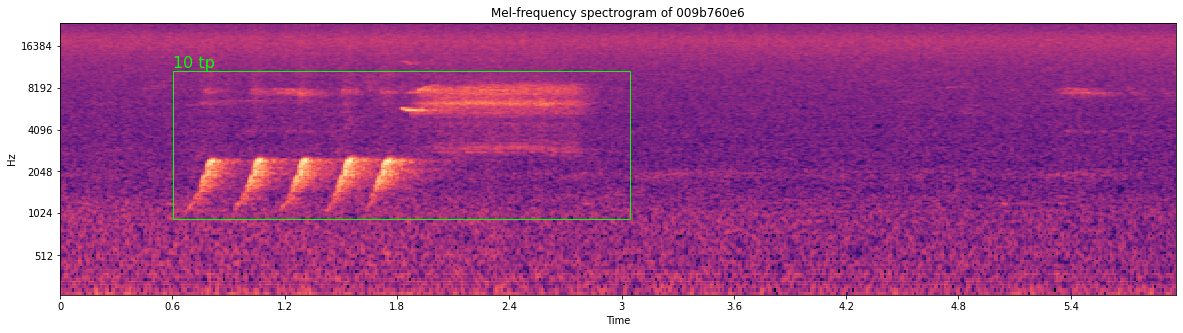

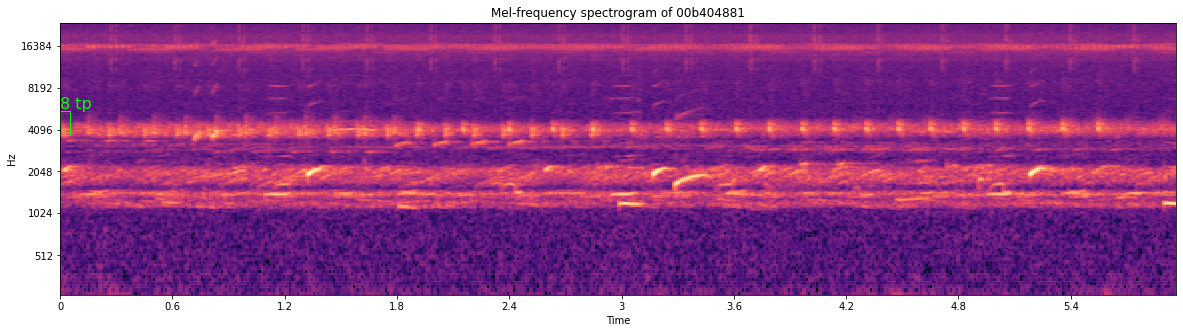

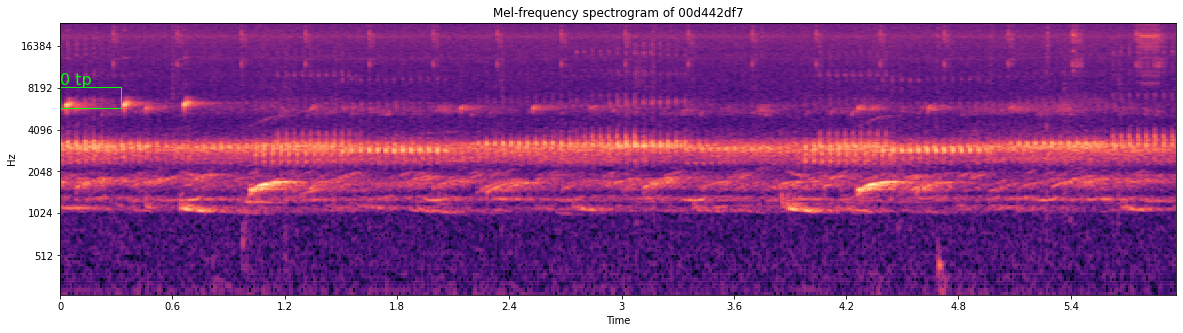

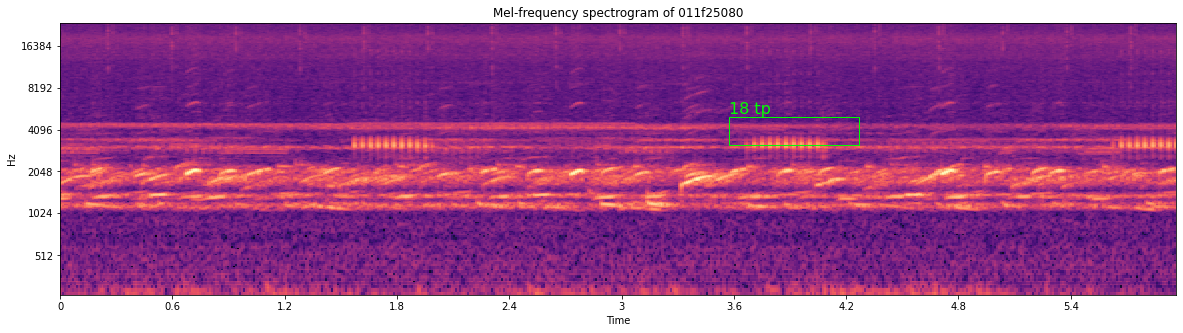

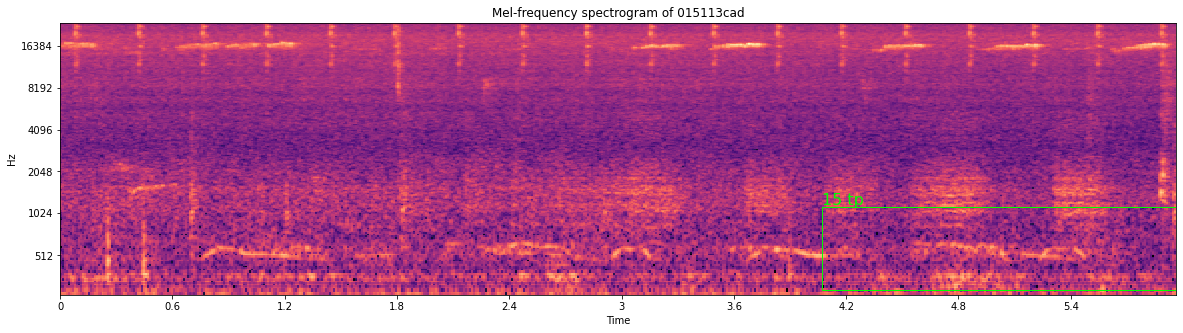

In [35]:
# parsed_dataset are the dataset that uses the random augmentation
for i,sam in enumerate(parsed_dataset):
    fig, ax = plt.subplots(figsize=(20,5))
    show_spectrogram(sam, ax, showlabel=True)
    if i > 7:
        break

# Create labels

In [36]:
@tf.function
def _create_annot(sample):
    """
    Creates a CLASS N number of columns for each sample and return dict
    """
    targ = tf.one_hot(sample["species_id"], CLASS_N, on_value=sample["is_tp"], off_value=0)
    
    return {
        'audio_spec': sample["audio_spec"],
        'target': tf.cast(targ, tf.float32)
    }

annot_dataset = parsed_dataset.map(_create_annot)

In [37]:
# lets see how it output for a single sample
next(iter(annot_dataset))

{'audio_spec': <tf.Tensor: shape=(224, 559), dtype=float32, numpy=
 array([[-3.5926425, -2.7139118, -3.686812 , ..., -1.5139093, -3.3956184,
         -3.2433846],
        [-2.2173312, -5.3143544, -2.4407551, ..., -3.689217 , -1.9462208,
         -2.9408052],
        [-1.9152831, -5.0173826, -2.1387672, ..., -3.3879738, -1.6441159,
         -2.6390114],
        ...,
        [-2.8336842, -2.7251046, -2.498505 , ..., -2.43511  , -2.724898 ,
         -2.4041882],
        [-2.705899 , -2.4198976, -2.5491915, ..., -2.5385466, -2.4185138,
         -2.4834564],
        [-2.795486 , -2.9106817, -2.9472518, ..., -2.8736968, -2.8735857,
         -2.5828638]], dtype=float32)>,
 'target': <tf.Tensor: shape=(24,), dtype=float32, numpy=
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.], dtype=float32)>}

# Data-augmentation

In [38]:
#@tf.function
def _preprocess_img(x, training=False):
    """
    Helper function that preprocess images
    """
    # our current input is (224,559), we need a channel
    # so expand_dim will add 1 to become (224,559,1)
    image = tf.expand_dims(x, axis=-1)
    # resize to (224,512,1)
    image = tf.image.resize(image, [HEIGHT, WIDTH])
    # standardize per image first before training
    image = tf.image.per_image_standardization(image)
    
#     @tf.function
#     def _specaugment(image):
#         """issue after tf 2.4
#         will not use until resolved...
#         """
#         ERASE_TIME = 50
#         ERASE_MEL = 16
#         image = tf.expand_dims(image, axis=0)
#         xoff = tf.random.uniform([2], minval=ERASE_TIME//2, maxval=WIDTH-ERASE_TIME//2, dtype=tf.int32)
#         xsize = tf.random.uniform([2], minval=ERASE_TIME//2, maxval=ERASE_TIME, dtype=tf.int32)
#         yoff = tf.random.uniform([2], minval=ERASE_MEL//2, maxval=HEIGHT-ERASE_MEL//2, dtype=tf.int32)
#         ysize = tf.random.uniform([2], minval=ERASE_MEL//2, maxval=ERASE_MEL, dtype=tf.int32)
#         image = tfa.image.cutout(image, [HEIGHT, xsize[0]], offset=[HEIGHT//2, xoff[0]])
#         image = tfa.image.cutout(image, [HEIGHT, xsize[1]], offset=[HEIGHT//2, xoff[1]])
#         image = tfa.image.cutout(image, [ysize[0], WIDTH], offset=[yoff[0], WIDTH//2])
#         image = tfa.image.cutout(image, [ysize[1], WIDTH], offset=[yoff[1], WIDTH//2])
#         image = tf.squeeze(image, axis=0)
#         return image
    
    def _specaugment2(image):
        """Reworked version using in-build function
        """
        # since it works only on 2d, lets remove the "channel" first
        # then add back later
        image = tf.squeeze(image, axis=-1)
        ERASE_TIME = 50
        ERASE_MEL = 16
        # Freq masking
        image = tfio.experimental.audio.freq_mask(image, param=ERASE_MEL)
        image = tfio.experimental.audio.time_mask(image, param=ERASE_TIME)
        # add back channel
        image = tf.expand_dims(image, axis=-1)

        return image
    
        
    # randomly decide if we will do the augmentation for training 
    if training:
        # gaussian
        gau = tf.keras.layers.GaussianNoise(0.3)
        image = tf.cond(tf.random.uniform([]) < 0.5, lambda: gau(image, training=True), lambda: image)
        # brightness
        image = tf.image.random_brightness(image, 0.2)
    
        # specaugment
        # uses custom augmentation
        image = tf.cond(tf.random.uniform([]) < 0.5, lambda: _specaugment2(image), lambda: image)
        
        # additional augmentation
        #image = tf.cond(tf.random.uniform([]) < 0.5, lambda: tf.image.random_flip_left_right(image), lambda: image)
        image = tf.cond(tf.random.uniform([]) < 0.5, lambda: tf.image.random_flip_up_down(image), lambda: image)
        
    image = (image - tf.reduce_min(image)) / (tf.reduce_max(image) - tf.reduce_min(image)) * 255.0 # rescale to [0, 255]
    # convert from 1 channel to 3. last dim (channel) must be 1
    image = tf.image.grayscale_to_rgb(image)
    image = cfg['model_params']['arch_preprocess'](image)

    return image

@tf.function
def _preprocess(x):
    """
    main calling function that calls _preprocessing_img on each dataset's sample dict key "input"
    and returns tuple (as required by model)
    """
    image = _preprocess_img(x['audio_spec'], True)
    
    return ({'input_1':image}, x["target"])

@tf.function
def _preprocess_val(x):
    image = _preprocess_img(x['audio_spec'], False)
    return ({'input_1':image}, x["target"])

@tf.function
def _preprocess_test(x):
    image = _preprocess_img(x['audio_spec'], False)
    return ({'input_1':image}, x["recording_id"])

In [39]:
# we will need to call map to the annotated data 
# _preprocess returns tuple of (image, label)

temp = parsed_dataset.map(_create_annot).map(_preprocess)

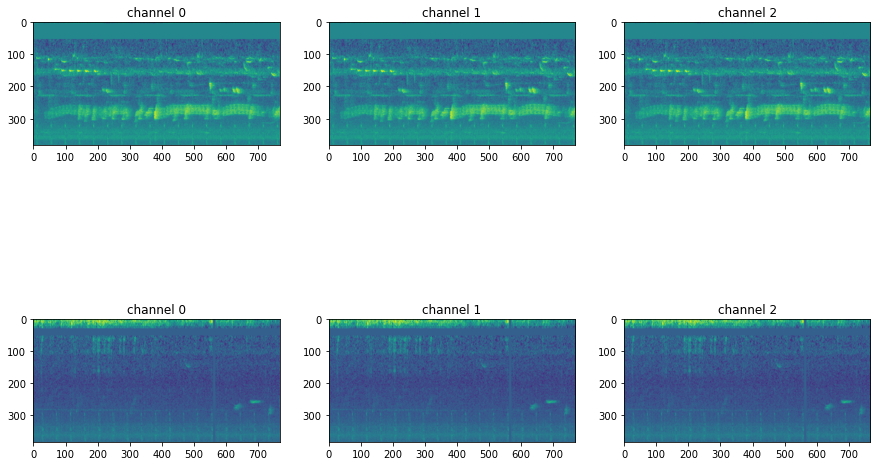

In [40]:
# (img, label) so we only need img and plot the first channel
# because we convert from grey scale to rgb, it will be the same for all channels 
fig,axes = plt.subplots(figsize = (15,10),nrows=2,ncols = 3)
for i,sam in enumerate(temp):
    for j in range(3):
        axes[i,j].imshow(sam[0]['input_1'][:,:,j])
        axes[i,j].set_title(f"channel {j}")
    if i == 1:
        break

In [41]:
@tf.function
def _mixup(batch_input_dict, batch_target):
    """
    Mix-up blending to a batch of images. We blend the image as well as the target 
    
    Apply to a dataset.batch(batchsize) which returns a tuple of 
    ((batch_size, h,w,channel) , (batch_size,N_class) )
    
    
    https://towardsdatascience.com/2-reasons-to-use-mixup-when-training-yor-deep-learning-models-58728f15c559
    """
    batch_input = batch_input_dict['input_1']
    
    indice = tf.range(len(batch_input)) # creates tensor [0,1,..., batch_size-1]
    indice = tf.random.shuffle(indice) # shuffle 
    sinp = tf.gather(batch_input, indice, axis=0) # get the batch input according to the shuffled index
    starg = tf.gather(batch_target, indice, axis=0) # get the target input according to the shuffled index
    
    alpha = 0.2
    
    # each image in the batch will have a different alpha
    t = tf.compat.v1.distributions.Beta(alpha, alpha).sample([len(batch_input)])
    
    
    # we have batch_size number of alphas and we want to apply the alphas to
    # the 3D image for each batch. Hence we need to convert the alpha to 3D too
    # with a size of (1,1,1)
    tx = tf.reshape(t, [-1, 1, 1, 1])
    ty = tf.reshape(t, [-1, 1])
    
    # apply mix up by blending each image in the batch with another image pair (shuffled within the batch)
    # with alpha and 1-alpha
    x = batch_input * tx + sinp * (1-tx) 
    
    # this results in probability. should we convert to all 1.0??? 
    #     y = tf.minimum(targ + starg, 1.0) # for multi-label???
    y = batch_target * ty + starg * (1-ty)

    return ({'input_1':x}, y)


# Model

In [42]:
# to do: add build_graph to view summary 
# Extend to simple attention architecture 
# adding CNN blocks is possible on top of pre-train models
# https://www.kaggle.com/kmader/attention-on-pretrained-vgg16-for-bone-age#Attention-Model
class channelAttention(tf.keras.Model):
    """
    https://github.com/lRomul/argus-freesound/blob/master/src/models/simple_attention.py
    
    https://paperswithcode.com/method/channel-attention-module#
    
    avg pooling input as well as separate max pooling input which connects to a common
    FC layer (instead of using MLP, Conv2D layer is used), sum them up and add a sigmoid
    activation 
    """
    def __init__(self,in_planes,ratio=16):
        """
        Parameters
        ----------
        
        in_planes: input channel size. We need to define this because the attention layers
        are after the convblocks which we should know the output channel size based on our
        filter size 
        """
        super().__init__()
        self.in_channel = in_planes
        
        # this is equals to global pooling 
        # AdaptiveAvgPool2d(1)
        self.avg_pool = tf.keras.layers.GlobalAveragePooling2D()
        self.max_pool = tf.keras.layers.GlobalMaxPool2D()
        
        
        self.fc1 = tf.keras.layers.Conv2D(filters=in_planes//ratio, kernel_size = 1, use_bias = False)
        self.relu1 = tf.keras.layers.ReLU()
        self.fc2 = tf.keras.layers.Conv2D(filters= in_planes, kernel_size = 1,use_bias = False)
        
    def call(self,inputs):
        # we reshape after pooling to emulate the pytorch adaptive pooling (1) which results in (channel,1,1)
        # for tensorflow, we want it to be (None,1,1,24) where 24 is the channel number 
        avg_out = tf.reshape(self.avg_pool(inputs),(-1,1,1,self.in_channel))
        avg_out = self.fc2(self.relu1(self.fc1(avg_out)))
        max_out = tf.reshape(self.max_pool(inputs),(-1,1,1,self.in_channel))
        max_out = self.fc2(self.relu1(self.fc1(max_out)))
        out = avg_out + max_out
        return tf.keras.activations.sigmoid(out)
    
class spatialAttention(tf.keras.Model):
    
    def __init__(self, kernel_size = 7):
        super().__init__()
        
        # some checks in the repo 
        assert kernel_size in (3, 7), 'kernel size must be 3 or 7'
        padding = 3 if kernel_size == 7 else 1
        
        # keras does not allow us to define the padding in conv2d, instead we do padding, the
        self.padding = tf.keras.layers.ZeroPadding2D(padding = padding)
        self.conv1 = tf.keras.layers.Conv2D(filters = 1, kernel_size = kernel_size, use_bias = False)
        
    def call(self,inputs):
        avg_out = tf.reduce_mean(inputs,axis = 1, keepdims = True)
        max_out = tf.reduce_max(inputs, axis = 1, keepdims = True)
        
        out = tf.keras.layers.concatenate([avg_out,max_out])
        out = self.conv1(self.padding(out))
        
        return tf.keras.activations.sigmoid(out)
    
class ConvolutionalBlockAttentionModule(tf.keras.Model):
    """
    in_planes: expected shape of the last dim (usually channel)
    """
    def __init__(self, in_planes, ratio = 16, kernel_size = 7):
        super().__init__()
        
        self.ca = channelAttention(in_planes=in_planes,ratio=ratio)
        self.sa = spatialAttention(kernel_size=kernel_size)
        
    def call(self,inputs):
        # multiple the input with a sigmoid score 
        # (in attention models, it is the softmax score)
        out = self.ca(inputs) * inputs
        out = self.sa(inputs) * out
        return out
    
class ConvBlock(tf.keras.Model):
    
    def __init__(self, out_channels):
        super().__init__()
        
        self.padding = tf.keras.layers.ZeroPadding2D(padding = 1)
        self.conv1= tf.keras.layers.Conv2D(filters = out_channels, kernel_size = 3, strides = 1, use_bias = False)
        self.batch_normalization_1 = tf.keras.layers.BatchNormalization()
        self.relu1 = tf.keras.layers.ReLU()
        
        self.padding2 = tf.keras.layers.ZeroPadding2D(padding = 1)
        self.conv2= tf.keras.layers.Conv2D(filters = out_channels, kernel_size = 3, strides = 1, use_bias = False)
        self.batch_normalization_2 = tf.keras.layers.BatchNormalization()
        self.relu2 = tf.keras.layers.ReLU()
        self.avg_pool = tf.keras.layers.AveragePooling2D()
    
    def call(self,inputs):
        x = self.padding(inputs)
        x = self.conv1(x)
        x = self.batch_normalization_1(x)
        x = self.relu1(x)
        
        x = self.padding2(x)
        x = self.conv2(x)
        x = self.batch_normalization_2(x)
        x = self.relu2(x)
        #x = tf.nn.avg_pool2d(x,2,2,"VALID") # follows pytorch default
        x = self.avg_pool(x)
        
        return x
    
    
class my_model(tf.keras.Model):
    
    def __init__(self,num_class =24, base_size= 64, ratio = 16, kernel_size = 7, drop_out = 0.2):
        super().__init__()
        
        # define our pre-trained model
        # we dont want the head and want to define our FCL
        self.base_model = tf.keras.applications.DenseNet121(include_top=False, weights = "imagenet", input_shape = (HEIGHT,WIDTH,3))
        
        # we want to train only the FCL
        # if our config defined None, we will freeze all, else only freeze the first [:layers]
        if cfg['model_params']['freeze_to'] is None:
            for layer in self.base_model.layers:
                layer.trainable = False
        else:
            # cfg defaults to :0
            # means we want to freeze nothing 
            for layer in self.base_model.layers[:cfg['model_params']['freeze_to']]:
                layer.trainable = False
        self.conv1 = ConvBlock(out_channels = base_size*4)
        self.conv = ConvBlock(out_channels = base_size*8)
        self.avg_pool = tf.keras.layers.AveragePooling2D()
        self.attention = self.attention = ConvolutionalBlockAttentionModule(in_planes = 512,ratio = ratio, kernel_size= kernel_size) # last dim from convo block is 512
        self.global_avg_pooling2d = tf.keras.layers.GlobalAveragePooling2D()
        self.batch_normalization_0 = tf.keras.layers.BatchNormalization()
        self.batch_normalization_1 = tf.keras.layers.BatchNormalization()
        self.batch_normalization_2 = tf.keras.layers.BatchNormalization()
        self.drop_out_1 = tf.keras.layers.Dropout(drop_out)
        self.drop_out_2 = tf.keras.layers.Dropout(drop_out)
        
        
        self.dense1 = tf.keras.layers.Dense(base_size * 2,activation=PReLU())
        self.dense2 = tf.keras.layers.Dense(CLASS_N)
        
    def call(self, inputs):
        y = self.base_model(inputs['input_1'])
        y = self.batch_normalization_0(y)
        y = self.conv1(y)
        y = self.conv(y)
        y = self.attention(y)
        y = self.global_avg_pooling2d(y)
#         y = self.batch_normalization_1(y)
        y = self.drop_out_1(y)
        y = self.dense1(y)
        y = self.batch_normalization_2(y)
        y = self.drop_out_2(y)
        y = self.dense2(y)        
        return y
        
        

In [43]:
#model = my_model()

In [44]:
tfrecs = sorted(tf.io.gfile.glob(TRAIN_TFREC + '/*.tfrec'))
parsed_trainval = (tf.data.TFRecordDataset(tfrecs, num_parallel_reads=AUTOTUNE)
                    .map(_parse_function, num_parallel_calls=AUTOTUNE).unbatch()
                    .filter(_filtTP).enumerate()) # this adds enumerate to the iterator. iterator now returns tuple (i,sample)

# Create validation strategy

Because sklearn's skf only works on pandas, we will get all the index of the dataset 

In [45]:
df = pd.DataFrame()

# if dev, do not run with .prefetch 
for i, sample in tqdm(parsed_trainval.prefetch(AUTOTUNE)):
    row = pd.DataFrame()
    row['indices'] = [i.numpy()]
    row['species_id'] = [sample['species_id'].numpy()]
    row['recording_id'] = [sample['recording_id'].numpy().decode()]
    df = pd.concat([df,row],axis = 0, sort = False)

1216it [00:58, 20.75it/s]


In [46]:
# dataframe containing all TFrecords for training and validation. we will split the validation using this 
df

indices  species_id recording_id
0         0          14    003bec244
0         1          12    2026bced7
0         2          21    422de4e4d
0         3           6    60a493ad4
0         4          13    8080b2283
..      ...         ...          ...
0      1211           3    807efd6bb
0      1212          20    a6610076b
0      1213          23    c91cae4aa
0      1214           3    c91cae4aa
0      1215           1    e755e15ec

[1216 rows x 3 columns]

In [47]:
def create_idx_filter(indice):
    """
    Predicate function for .filter()
    Given a tensor of indexes, we will return True if
    enumerate index matches the tensor of indexes
    """
    @tf.function
    def _filt(i, x):
        # reduce_any performs OR operation in each array
        return tf.reduce_any(indice == i) # [True ,False. False] returns True. as long as index enumerate is inside indice tensor, will return True
    return _filt

@tf.function
def _remove_idx(i, sample):
    """
    simply return sample and remove the i enumerator
    """
    return sample

def create_train_dataset(batchsize, train_idx):
    """
    
    Parameters
    ----------
    batchsize: int 
    train_idx: a tensor containing all the train_index from skf.split
    """
    global parsed_trainval
    parsed_train = (parsed_trainval
                    .filter(create_idx_filter(train_idx))
                    .map(_remove_idx))
    
    dataset = (parsed_train.cache()
        .shuffle(len(train_idx))
        .repeat()
        .map(_cut_wav, num_parallel_calls=AUTOTUNE)
        .map(convert_mel_spectrogram_param, num_parallel_calls=AUTOTUNE)
        .map(_create_annot, num_parallel_calls=AUTOTUNE)
        .map(_preprocess, num_parallel_calls=AUTOTUNE)
        .batch(batchsize))

    if cfg['model_params']['mixup']:
        dataset = (dataset.map(_mixup, num_parallel_calls=AUTOTUNE)
                    .prefetch(AUTOTUNE))
    else:
        dataset = dataset.prefetch(AUTOTUNE)
    return dataset

def create_val_dataset(batchsize, val_idx):
    global parsed_trainval
    parsed_val = (parsed_trainval
                  .filter(create_idx_filter(val_idx))
                  .map(_remove_idx))

    vdataset = (parsed_val
        .map(_cut_wav_val, num_parallel_calls=AUTOTUNE)
        .map(convert_mel_spectrogram_param, num_parallel_calls=AUTOTUNE)
        .map(_create_annot, num_parallel_calls=AUTOTUNE)
        .map(_preprocess_val, num_parallel_calls=AUTOTUNE)
        .batch(8*strategy.num_replicas_in_sync)
        .cache())
    return vdataset

# Metrics 

In [48]:
# from https://www.kaggle.com/carlthome/l-lrap-metric-for-tf-keras
@tf.function
def _one_sample_positive_class_precisions(example):
    y_true, y_pred = example

    retrieved_classes = tf.argsort(y_pred, direction='DESCENDING')
    class_rankings = tf.argsort(retrieved_classes)
    retrieved_class_true = tf.gather(y_true, retrieved_classes)
    retrieved_cumulative_hits = tf.math.cumsum(tf.cast(retrieved_class_true, tf.float32))

    idx = tf.where(y_true)[:, 0]
    i = tf.boolean_mask(class_rankings, y_true)
    r = tf.gather(retrieved_cumulative_hits, i)
    c = 1 + tf.cast(i, tf.float32)
    precisions = r / c

    dense = tf.scatter_nd(idx[:, None], precisions, [y_pred.shape[0]])
    return dense

class LWLRAP(tf.keras.metrics.Metric):
    def __init__(self, num_classes, name='lwlrap'):
        super().__init__(name=name)

        self._precisions = self.add_weight(
            name='per_class_cumulative_precision',
            shape=[num_classes],
            initializer='zeros',
        )

        self._counts = self.add_weight(
            name='per_class_cumulative_count',
            shape=[num_classes],
            initializer='zeros',
        )

    def update_state(self, y_true, y_pred, sample_weight=None):
        precisions = tf.map_fn(
            fn=_one_sample_positive_class_precisions,
            elems=(y_true, y_pred),
            dtype=(tf.float32),
        )

        increments = tf.cast(precisions > 0, tf.float32)
        total_increments = tf.reduce_sum(increments, axis=0)
        total_precisions = tf.reduce_sum(precisions, axis=0)

        self._precisions.assign_add(total_precisions)
        self._counts.assign_add(total_increments)        

    def result(self):
        per_class_lwlrap = self._precisions / tf.maximum(self._counts, 1.0)
        per_class_weight = self._counts / tf.reduce_sum(self._counts)
        overall_lwlrap = tf.reduce_sum(per_class_lwlrap * per_class_weight)
        return overall_lwlrap

    def reset_states(self):
        self._precisions.assign(self._precisions * 0)
        self._counts.assign(self._counts * 0)

In [49]:
def _parse_function_test(example_proto):
    """
    Multiple inference (of length TIME) on the test set, then take max
    """
    sample = tf.io.parse_single_example(example_proto, feature_description)
    wav, _ = tf.audio.decode_wav(sample['audio_wav'], desired_channels=1) # mono
    
    @tf.function
    def _cut_audio(i):
        _sample = {
            'audio_wav': tf.reshape(wav[i*SR*TIME:(i+1)*SR*TIME], [SR*TIME]),
            'recording_id': sample['recording_id']
        }
        return _sample

    return tf.map_fn(_cut_audio, tf.range(60//TIME), dtype={
        'audio_wav': tf.float32,
        'recording_id': tf.string
    })

def inference(model):
    tdataset = (tf.data.TFRecordDataset(tf.io.gfile.glob(TEST_TFREC + '/*.tfrec'), num_parallel_reads=AUTOTUNE)
        .map(_parse_function_test, num_parallel_calls=AUTOTUNE).unbatch()
        .map(convert_mel_spectrogram_param, num_parallel_calls=AUTOTUNE)
        .map(_preprocess_test, num_parallel_calls=AUTOTUNE)
        .batch(128*(60//TIME)).prefetch(AUTOTUNE))
    
    rec_ids = []
    probs = []
    for inp, rec_id in tqdm(tdataset):
        with strategy.scope():
            #pred = model.predict_on_batch(tf.reshape(inp['input_1'], [-1, HEIGHT, WIDTH, 3]))
            pred = model.predict_on_batch(inp) # model.predict takes in a dict with key input_1 (based on our model subclass)
            prob = tf.sigmoid(pred)
            prob = tf.reduce_max(tf.reshape(prob, [-1, 60//TIME, CLASS_N]), axis=1)

        rec_id_stack = tf.reshape(rec_id, [-1, 60//TIME])
        for rec in rec_id.numpy():
            assert len(np.unique(rec)) == 1
        rec_ids.append(rec_id_stack.numpy()[:,0])
        probs.append(prob.numpy())
        
    crec_ids = np.concatenate(rec_ids)
    cprobs = np.concatenate(probs)
    
    sub = pd.DataFrame({
        'recording_id': list(map(lambda x: x.decode(), crec_ids.tolist())),
        **{f's{i}': cprobs[:,i] for i in range(CLASS_N)}
    })
    sub = sub.sort_values('recording_id')
    return sub

In [50]:
def plot_history(history, name,loss_list,lwlrp_list):
    plt.figure(figsize=(8,3))
    plt.subplot(1,2,1)
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.title("loss")
    # plt.yscale('log')

    plt.subplot(1,2,2)
    plt.plot(history.history["lwlrap"])
    plt.plot(history.history["val_lwlrap"])
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.title("metric")
    
    val_loss = history.history["val_loss"]
    val_loss = val_loss[-1]
    loss_list.append(val_loss)
    
    val_lwlrap = history.history["val_lwlrap"]
    val_lwlrap = val_lwlrap[-1]
    lwlrp_list.append(val_lwlrap)
    
    logger.info(f"val loss: {val_loss}")
    logger.info(f"val lwlrap: {val_lwlrap}")

    plt.savefig(name)
    return loss_list,lwlrp_list

In [51]:
def train_and_inference(splits, split_id,loss_list,lwlrp_list):
    batchsize = cfg['model_params']['batchsize_per_tpu'] * strategy.num_replicas_in_sync
    print("batchsize", batchsize)
    loss_fn = cfg['model_params']['loss']['fn'](from_logits=True, **cfg['model_params']['loss']['params'])

    # convert list of index to tensor array
    train_index = tf.constant(splits[split_id][0])
    val_index = tf.constant(splits[split_id][1])
    
    
    # pass the tensor array defining train and test and filter out the samples 
    dataset = create_train_dataset(batchsize, train_index)
    vdataset = create_val_dataset(batchsize, val_index)
    
    
    optimizer = cfg['model_params']['optim']['fn'](**cfg['model_params']['optim']['params'])
    
    with strategy.scope():
        model = my_model()
        model.compile(optimizer=optimizer, loss=loss_fn, metrics=[LWLRAP(CLASS_N)])
    
    # TODO: add callback for epoch saving
    call_back_list = []

    # add lr 

    call_back_list.append(tf.keras.callbacks.ReduceLROnPlateau(
                                    'val_lwlrap', patience=10
                                ))

    # model check point 
    call_back_list.append(tf.keras.callbacks.ModelCheckpoint(
                                    filepath='model_best_%d.h5' % split_id,
                                    save_weights_only=True,
                                    monitor='val_lwlrap',
                                    mode='max',
                                    save_best_only=True))

    # early stopping
    call_back_list.append(tf.keras.callbacks.EarlyStopping(monitor = "val_lwlrap", mode = "max", patience = 5))

    history = model.fit(dataset,
                        steps_per_epoch=cfg['model_params']['iteration_per_epoch'],
                        epochs=cfg['model_params']['epoch'],
                        validation_data=vdataset,
                        callbacks=call_back_list)
    loss_list,lwlrp_list = plot_history(history, 'history_%d.png' % split_id,loss_list,lwlrp_list)
    
    ### inference ###
    model.load_weights('model_best_%d.h5' % split_id)
    return inference(model), history, loss_list,lwlrp_list

In [52]:
skf = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)
splits = list(skf.split(df.index, df.species_id))

2021-02-09 16:39:49.065 | INFO     | __main__:<module>:6 - **Fold 0


batchsize 128
29089792/29084464 [==============================] - 0s 0us/step
Epoch 1/25
64/64 [==============================] - 261s 1s/step - loss: 3.3990 - lwlrap: 0.1422 - val_loss: 2.9741 - val_lwlrap: 0.1769
Epoch 2/25
64/64 [==============================] - 31s 482ms/step - loss: 2.9579 - lwlrap: 0.1463 - val_loss: 2.8124 - val_lwlrap: 0.1547
Epoch 3/25
64/64 [==============================] - 31s 488ms/step - loss: 2.7121 - lwlrap: 0.1541 - val_loss: 2.1095 - val_lwlrap: 0.1548
Epoch 4/25
64/64 [==============================] - 31s 481ms/step - loss: 1.7759 - lwlrap: 0.1760 - val_loss: 0.7799 - val_lwlrap: 0.1576
Epoch 5/25
64/64 [==============================] - 31s 480ms/step - loss: 0.6405 - lwlrap: 0.2170 - val_loss: 0.4077 - val_lwlrap: 0.1884
Epoch 6/25
64/64 [==============================] - 31s 491ms/step - loss: 0.3693 - lwlrap: 0.4185 - val_loss: 0.3795 - val_lwlrap: 0.3727
Epoch 7/25
64/64 [==============================] - 31s 483ms/step - loss: 0.2910 - lwlra

2021-02-09 16:53:40.518 | INFO     | __main__:plot_history:24 - val loss: 0.18470162153244019
2021-02-09 16:53:40.519 | INFO     | __main__:plot_history:25 - val lwlrap: 0.842179536819458
16it [02:09,  8.12s/it]
2021-02-09 16:55:56.089 | INFO     | __main__:<module>:6 - **Fold 1


batchsize 128
Epoch 1/25
64/64 [==============================] - 262s 1s/step - loss: 3.4035 - lwlrap: 0.1432 - val_loss: 2.9727 - val_lwlrap: 0.1502
Epoch 2/25
64/64 [==============================] - 31s 483ms/step - loss: 2.9502 - lwlrap: 0.1893 - val_loss: 2.8016 - val_lwlrap: 0.1835
Epoch 3/25
64/64 [==============================] - 31s 486ms/step - loss: 2.6885 - lwlrap: 0.2116 - val_loss: 2.0753 - val_lwlrap: 0.1794
Epoch 4/25
64/64 [==============================] - 31s 480ms/step - loss: 1.7425 - lwlrap: 0.2204 - val_loss: 0.7658 - val_lwlrap: 0.1873
Epoch 5/25
64/64 [==============================] - 32s 493ms/step - loss: 0.6329 - lwlrap: 0.2840 - val_loss: 0.3943 - val_lwlrap: 0.3291
Epoch 6/25
64/64 [==============================] - 31s 489ms/step - loss: 0.3436 - lwlrap: 0.5996 - val_loss: 0.3812 - val_lwlrap: 0.3749
Epoch 7/25
64/64 [==============================] - 31s 486ms/step - loss: 0.2461 - lwlrap: 0.7825 - val_loss: 0.4059 - val_lwlrap: 0.3054
Epoch 8/25
64/6

2021-02-09 17:11:05.533 | INFO     | __main__:plot_history:24 - val loss: 0.1708204299211502
2021-02-09 17:11:05.534 | INFO     | __main__:plot_history:25 - val lwlrap: 0.85539710521698
16it [02:19,  8.74s/it]
2021-02-09 17:13:31.116 | INFO     | __main__:<module>:6 - **Fold 2


batchsize 128
Epoch 1/25
64/64 [==============================] - 265s 1s/step - loss: 3.4531 - lwlrap: 0.1293 - val_loss: 2.9720 - val_lwlrap: 0.1521
Epoch 2/25
64/64 [==============================] - 31s 481ms/step - loss: 2.9603 - lwlrap: 0.1582 - val_loss: 2.8254 - val_lwlrap: 0.1493
Epoch 3/25
64/64 [==============================] - 31s 482ms/step - loss: 2.7160 - lwlrap: 0.1573 - val_loss: 2.1240 - val_lwlrap: 0.1547
Epoch 4/25
64/64 [==============================] - 31s 482ms/step - loss: 1.7833 - lwlrap: 0.1970 - val_loss: 0.7988 - val_lwlrap: 0.1648
Epoch 5/25
64/64 [==============================] - 31s 482ms/step - loss: 0.6427 - lwlrap: 0.2582 - val_loss: 0.4081 - val_lwlrap: 0.2612
Epoch 6/25
64/64 [==============================] - 31s 485ms/step - loss: 0.3622 - lwlrap: 0.4583 - val_loss: 0.3743 - val_lwlrap: 0.3873
Epoch 7/25
64/64 [==============================] - 31s 485ms/step - loss: 0.2847 - lwlrap: 0.6207 - val_loss: 0.3912 - val_lwlrap: 0.3946
Epoch 8/25
64/6

2021-02-09 17:28:07.140 | INFO     | __main__:plot_history:24 - val loss: 0.168513685464859
2021-02-09 17:28:07.141 | INFO     | __main__:plot_history:25 - val lwlrap: 0.852965772151947
16it [02:27,  9.25s/it]
2021-02-09 17:30:40.132 | INFO     | __main__:<module>:6 - **Fold 3


batchsize 128
Epoch 1/25
64/64 [==============================] - 270s 1s/step - loss: 3.4895 - lwlrap: 0.1785 - val_loss: 2.9543 - val_lwlrap: 0.1625
Epoch 2/25
64/64 [==============================] - 31s 477ms/step - loss: 2.9518 - lwlrap: 0.1458 - val_loss: 2.7899 - val_lwlrap: 0.1570
Epoch 3/25
64/64 [==============================] - 31s 482ms/step - loss: 2.7096 - lwlrap: 0.1483 - val_loss: 2.1137 - val_lwlrap: 0.1600
Epoch 4/25
64/64 [==============================] - 31s 478ms/step - loss: 1.8075 - lwlrap: 0.2141 - val_loss: 0.8071 - val_lwlrap: 0.1611
Epoch 5/25
64/64 [==============================] - 31s 479ms/step - loss: 0.6610 - lwlrap: 0.2248 - val_loss: 0.4113 - val_lwlrap: 0.2060
Epoch 6/25
64/64 [==============================] - 31s 489ms/step - loss: 0.3640 - lwlrap: 0.4572 - val_loss: 0.3892 - val_lwlrap: 0.2842
Epoch 7/25
64/64 [==============================] - 31s 481ms/step - loss: 0.2696 - lwlrap: 0.6934 - val_loss: 0.4110 - val_lwlrap: 0.2895
Epoch 8/25
64/6

2021-02-09 17:48:31.211 | INFO     | __main__:plot_history:24 - val loss: 0.21072541177272797
2021-02-09 17:48:31.212 | INFO     | __main__:plot_history:25 - val lwlrap: 0.8253359198570251
16it [02:15,  8.45s/it]
2021-02-09 17:50:51.776 | INFO     | __main__:<module>:6 - **Fold 4


batchsize 128
Epoch 1/25
64/64 [==============================] - 267s 1s/step - loss: 3.3551 - lwlrap: 0.1380 - val_loss: 2.9722 - val_lwlrap: 0.1599
Epoch 2/25
64/64 [==============================] - 31s 484ms/step - loss: 2.9553 - lwlrap: 0.1488 - val_loss: 2.8061 - val_lwlrap: 0.1614
Epoch 3/25
64/64 [==============================] - 33s 512ms/step - loss: 2.6953 - lwlrap: 0.1534 - val_loss: 2.0627 - val_lwlrap: 0.1572
Epoch 4/25
64/64 [==============================] - 31s 484ms/step - loss: 1.7328 - lwlrap: 0.1698 - val_loss: 0.7589 - val_lwlrap: 0.1715
Epoch 5/25
64/64 [==============================] - 31s 482ms/step - loss: 0.6264 - lwlrap: 0.2761 - val_loss: 0.4093 - val_lwlrap: 0.2177
Epoch 6/25
64/64 [==============================] - 31s 486ms/step - loss: 0.3550 - lwlrap: 0.4596 - val_loss: 0.4031 - val_lwlrap: 0.1513
Epoch 7/25
64/64 [==============================] - 31s 479ms/step - loss: 0.2765 - lwlrap: 0.6623 - val_loss: 0.4111 - val_lwlrap: 0.1823
Epoch 8/25
64/6

2021-02-09 18:08:08.699 | INFO     | __main__:plot_history:24 - val loss: 0.1555536538362503
2021-02-09 18:08:08.700 | INFO     | __main__:plot_history:25 - val lwlrap: 0.8709402680397034
16it [02:31,  9.50s/it]


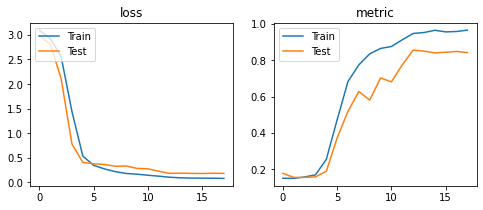

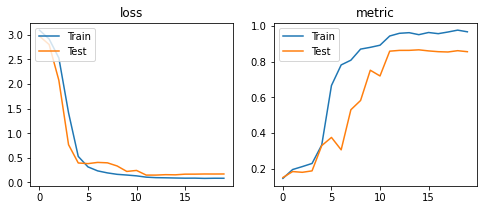

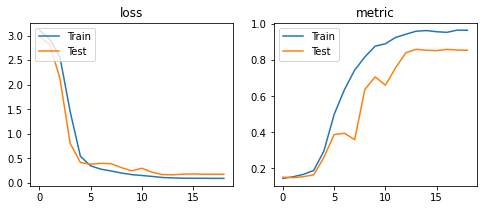

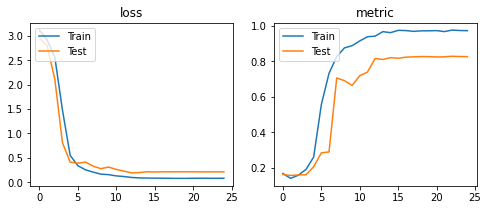

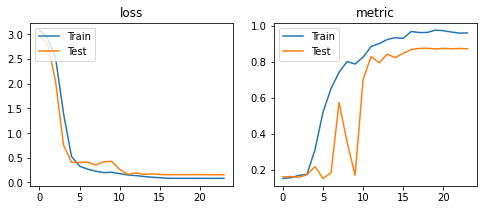

In [53]:
# train and inference
loss_list = []
lwlrp_list = []

for i in range(5):
    logger.info(f"**Fold {i}")
    sub, _, loss_list,lwlrp_list = train_and_inference(splits, i, loss_list,lwlrp_list)
    sub.to_csv(f"submission{i}.csv", index=False)
    del sub

In [54]:
logger.info(f"avg val loss: {np.mean(loss_list)}")
logger.info(f"avg val lwlrap: {np.mean(lwlrp_list)}")

2021-02-09 18:10:53.435 | INFO     | __main__:<module>:1 - avg val loss: 0.17806296050548553
2021-02-09 18:10:53.437 | INFO     | __main__:<module>:2 - avg val lwlrap: 0.8493637204170227
